In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Activation
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

In [13]:
df_ratings = pd.read_csv('data/corporateCreditRatingWithFinancialRatios.csv')
# rating_order = ['AAA', 'AA+', 'AA', 'AA-', 'A+', 'A', 'A-', 'BBB+', 'BBB', 'BBB-', 
#                 'BB+', 'BB', 'BB-', 'B+', 'B', 'B-', 'CCC+', 'CCC', 'CCC-', 'CC', 'C', 'D']
df_ratings['Rating'] = df_ratings['Rating'].str.replace("+","").str.replace("-","")
rating_order = ['AAA', 'AA', 'A', 'BBB', 'BB', 'B', 'CCC', 'CC', 'C', 'D']
df_filtered = df_ratings[df_ratings['Rating'].isin(rating_order)]
number_of_ratings = len(df_filtered['Rating'].unique())

In [14]:
# input_columns = ['Current Ratio', 'Long-term Debt / Capital', 'Debt/Equity Ratio',
#                  'Gross Margin', 'Operating Margin', 'EBIT Margin', 'EBITDA Margin',
#                  'Pre-Tax Profit Margin', 'Net Profit Margin', 'Asset Turnover',
#                  'ROE - Return On Equity', 'Return On Tangible Equity',
#                  'ROA - Return On Assets', 'ROI - Return On Investment',
#                  'Operating Cash Flow Per Share', 'Free Cash Flow Per Share']

input_columns = ['Operating Margin', 'EBIT Margin', 'EBITDA Margin', 'Pre-Tax Profit Margin', 'Net Profit Margin',
                 'ROA - Return On Assets', 'ROI - Return On Investment', 'Operating Cash Flow Per Share']

In [15]:
ranges = {
    "Current Ratio": (-5, 20),
    "Long-term Debt / Capital": (-25, 15),
    "Debt/Equity Ratio": (-200, 250),
    "Gross Margin": (-25, 150),
    "Operating Margin": (-250, 100),
    "EBIT Margin": (-200, 100),
    "EBITDA Margin": (-200, 100),
    "Pre-Tax Profit Margin": (-100, 150),
    "Net Profit Margin": (-150, 150),
    "Asset Turnover": (-10, 6),
    "ROE - Return On Equity": (-2500, 2500),
    "Return On Tangible Equity": (-2500, 2500),
    "ROA - Return On Assets": (-100, 80),
    "ROI - Return On Investment": (-250, 250),
    "Operating Cash Flow Per Share": (-80, 100),
    "Free Cash Flow Per Share": (-50, 50)
}

for column in input_columns:
    df_filtered.drop(df_filtered[(df_filtered[column] < ranges[column][0]) | (df_filtered[column] > ranges[column][1])].index, inplace=True)

In [16]:
X = df_filtered[input_columns].copy()
encoder = OrdinalEncoder(categories=[rating_order])
y = encoder.fit_transform(df_filtered[['Rating']]).astype(int).flatten()

In [17]:
X.describe()

,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share
count,7724.000000,7724.000000,7724.000000,7724.000000,7724.000000,7724.000000,7724.000000,7724.000000
mean,13.269472,13.318412,21.516629,10.422082,7.483785,5.036271,8.127554,0.555667
std,13.152717,13.175973,15.801068,13.966072,11.834945,5.966716,10.924754,4.597533
min,-95.629500,-95.629500,-78.951000,-97.331300,-99.015700,-49.752600,-148.372600,-61.817100
25%,6.299375,6.350400,11.212400,4.112100,2.765200,2.454175,3.876900,-0.427900
50%,12.196900,12.264200,18.439600,9.760800,6.970000,4.811400,7.504800,0.242350
75%,19.549000,19.554700,30.858325,16.738400,12.381100,7.896100,12.550250,1.094200
max,93.993000,93.993000,97.186600,131.386900,77.134800,38.823000,133.333300,67.406100


In [18]:
X.iloc[:, 0:-1] = StandardScaler().fit_transform(X.iloc[:, 0:-1].to_numpy())
X.describe()

,Operating Margin,EBIT Margin,EBITDA Margin,Pre-Tax Profit Margin,Net Profit Margin,ROA - Return On Assets,ROI - Return On Investment,Operating Cash Flow Per Share
count,7.724000e+03,7.724000e+03,7.724000e+03,7.724000e+03,7724.000000,7.724000e+03,7.724000e+03,7724.000000
mean,-5.151527e-17,1.287882e-16,-5.703476e-17,3.679662e-17,0.000000,-3.679662e-17,1.103899e-17,0.555667
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00,1.000065,1.000065e+00,1.000065e+00,4.597533
min,-8.280116e+00,-8.269216e+00,-6.358692e+00,-7.715867e+00,-8.999313,-9.183010e+00,-1.432621e+01,-61.817100
25%,-5.299702e-01,-5.288766e-01,-6.521645e-01,-4.518372e-01,-0.398725,-4.327779e-01,-3.891098e-01,-0.427900
50%,-8.155287e-02,-8.001537e-02,-1.947481e-01,-4.735226e-02,-0.043415,-3.768997e-02,-5.700758e-02,0.242350
75%,4.774629e-01,4.733382e-01,5.912449e-01,4.522909e-01,0.413828,4.793280e-01,4.048588e-01,1.094200
max,6.137800e+00,6.123253e+00,4.789225e+00,8.661895e+00,5.885581,5.662900e+00,1.146148e+01,67.406100


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),  # Primeira camada
    Dense(128, activation='tanh'),  # Nova camada adicionada
    Dense(64, activation='tanh'),  # 
    Dense(number_of_ratings, activation='softmax')  # Camada de saída
])
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

y_predict = model.predict(X_test)
y_predict = np.argmax(y_predict, axis=1)

Epoch 1/500


/home/cmore/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


194/194 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3537 - loss: 1.6783 - val_accuracy: 0.3806 - val_loss: 1.5010
Epoch 2/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3910 - loss: 1.4831 - val_accuracy: 0.3981 - val_loss: 1.4699
Epoch 3/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4005 - loss: 1.4326 - val_accuracy: 0.3631 - val_loss: 1.4741
Epoch 4/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3926 - loss: 1.4422 - val_accuracy: 0.4201 - val_loss: 1.4265
Epoch 5/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4039 - loss: 1.4158 - val_accuracy: 0.4227 - val_loss: 1.3981
Epoch 6/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4196 - loss: 1.3774 - val_accuracy: 0.4350 - val_loss: 1.3758
Epoch 7/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4267 - loss: 1.3548 - val_accuracy: 0.4343 - val_loss: 1.3733
Epoch 8/500
194/194 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4521 - loss: 1.3382 - val_accuracy: 0.4091

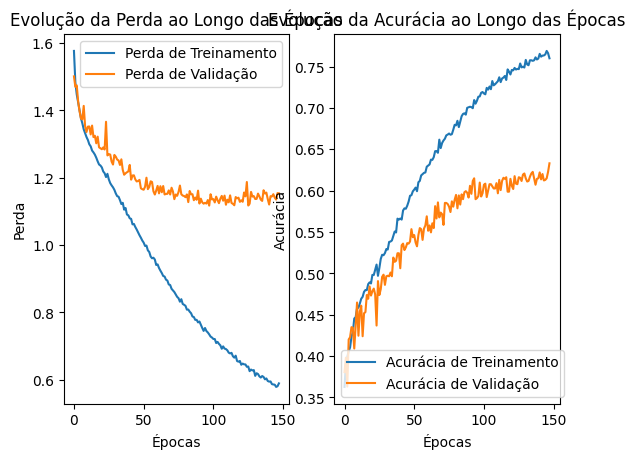

In [21]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perda de Treinamento')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Evolução da Perda ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico da acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.title('Evolução da Acurácia ao Longo das Épocas')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.show()

In [22]:
y_predict = model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [23]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy:.4f}")

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6251 - loss: 1.0799
Test accuracy: 0.6097


In [24]:
predictions = np.argmax(y_predict, axis=1)
actuals = y_test

# Decodificar os valores numéricos de volta para os rótulos originais
ratings = encoder.inverse_transform(predictions.reshape(-1, 1))
actual_ratings = encoder.inverse_transform(actuals.reshape(-1, 1))

# Criar um DataFrame com as previsões e os valores reais
df_comparison = pd.DataFrame({'Previsão': ratings.flatten(), 'Real': actual_ratings.flatten()})

# Mostrar até 100 registros
print(df_comparison.head(100))

   Previsão Real
0       CCC    B
1         B    B
2       BBB  BBB
3       BBB    B
4         B    B
..      ...  ...
95      BBB  BBB
96        A  BBB
97      CCC  CCC
98       BB   BB
99      BBB  BBB

[100 rows x 2 columns]


In [25]:
len(df_comparison[df_comparison['Previsão'] == df_comparison['Real']]) / len(df_comparison)

0.6097087378640776